In [2]:
import pandas as pd
from sentence_transformers import SentenceTransformer

/Users/abaziz/Documents/programming/portfolio-projects/stock-mood/backend/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv("../data/news_postprocess.csv", delimiter=";")
df.head()

,sentiment,text,words_count,neg,neu,pos,compound,sentiment_encoded
0,positive,"The apartment block will be well-located , in ...",22,0.121,0.711,0.167,0.0258,2
1,neutral,The sale of the food potato business is part o...,19,0.000,1.000,0.000,0.0000,1
2,positive,The Group 's business is balanced by its broad...,17,0.000,1.000,0.000,0.0000,2
3,positive,TeliaSonera said about $ 100 million will be i...,24,0.000,1.000,0.000,0.0000,2
4,neutral,The mall is part of the Baltic Pearl developme...,33,0.000,1.000,0.000,0.0000,1


In [4]:
encoder = SentenceTransformer("yiyanghkust/finbert-tone")
embeddings = encoder.encode(df["text"].to_list(), show_progress_bar=True)

No sentence-transformers model found with name yiyanghkust/finbert-tone. Creating a new one with mean pooling.
Batches: 100%|██████████| 57/57 [00:13<00:00,  4.20it/s]


In [5]:
import numpy as np

other_features = df[['words_count', 'neg', 'neu', 'pos', 'compound']].values

X = np.hstack([embeddings, other_features])
y = df['sentiment_encoded'].values 

print(X.shape)
print(y.shape)

(1812, 773)
(1812,)


In [6]:
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 1159
Validation set size: 290
Test set size: 363


In [65]:
# making the neural net
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

def create_model():
    model = Sequential([
        Dense(32, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.02)),
        Dropout(0.4),
        Dense(16, activation='relu', kernel_regularizer=l2(0.02)),
        Dropout(0.3),
        Dense(3, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [66]:
model = create_model()

model.summary()

/Users/abaziz/Documents/programming/portfolio-projects/stock-mood/backend/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 32)             │        24,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,347 (99.01 KB)

 Trainable params: 25,347 (99.01 KB)

 Non-trainable params: 0 (0.00 B)

In [67]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=0.001, 
    restore_best_weights=True
)


history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=500,
    batch_size=32,
    callbacks=[early_stopping],
)

Epoch 1/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3592 - loss: 2.8732 - val_accuracy: 0.4483 - val_loss: 2.6392
Epoch 2/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3365 - loss: 2.7468 - val_accuracy: 0.4828 - val_loss: 2.5796
Epoch 3/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3852 - loss: 2.6270 - val_accuracy: 0.4793 - val_loss: 2.5092
Epoch 4/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4077 - loss: 2.5364 - val_accuracy: 0.5207 - val_loss: 2.4352
Epoch 5/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4270 - loss: 2.4599 - val_accuracy: 0.5276 - val_loss: 2.3486
Epoch 6/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4345 - loss: 2.3902 - val_accuracy: 0.5517 - val_loss: 2.2655
Epoch 7/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4719 - loss: 2.3211 - val_accuracy: 0.5966 - val_loss: 2.1805
Epoch 8/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5051 - loss: 2.2427 - val_accuracy: 0.6448 - v

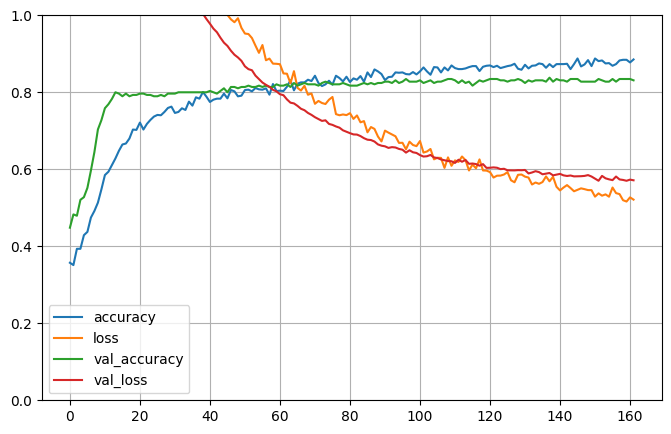

In [68]:
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

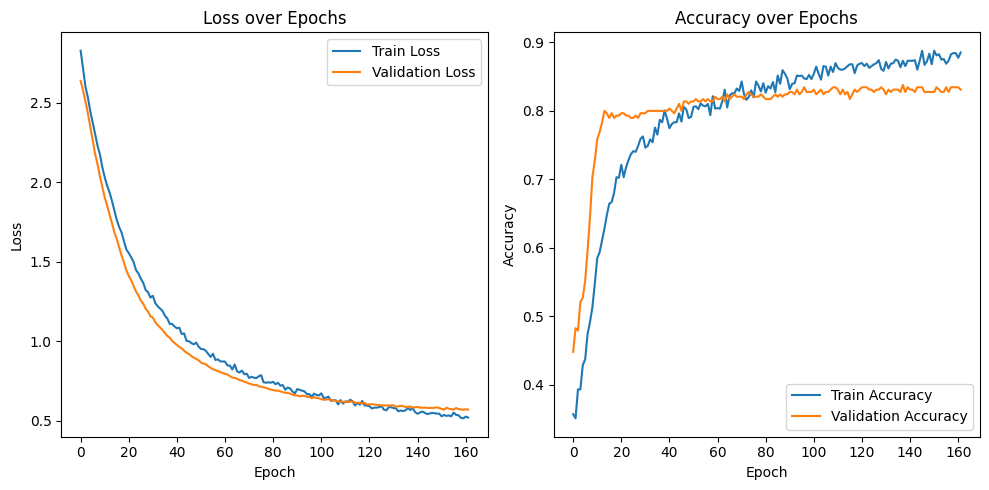

In [69]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.figure(figsize=(10, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [70]:
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
probs = model.predict(X_test)
y_pred = np.argmax(probs, axis=1)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['negative', 'neutral', 'positive']))

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Accuracy: 0.8154269972451791
Classification Report:
              precision    recall  f1-score   support

    negative       0.86      0.91      0.88       129
     neutral       0.74      0.79      0.76       107
    positive       0.84      0.75      0.79       127

    accuracy                           0.82       363
   macro avg       0.81      0.81      0.81       363
weighted avg       0.82      0.82      0.81       363



In [71]:
# confusion matrix
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_val).argmax(axis=1)
print(confusion_matrix(y_val, y_pred))

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[[85  6  2]
 [ 7 86 14]
 [ 8 11 71]]


In [72]:
# test
model.evaluate(X_test, y_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8334 - loss: 0.5422 


[0.5717763900756836, 0.8154270052909851]

In [73]:
# saving the model 
model.save("../models/model_v1.keras")